# RSL-RL Policy Performance Comparison

Comprehensive performance analysis focusing on **locomotion tasks**:
- Flat vs Rough terrain
- Different robot platforms (Anymal-C, Anymal-D, Unitree Go2)
- Direct locomotion vs Manager-based control

All comparisons focus on the latest checkpoints from training.

In [49]:
# Import libraries and utilities
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

# Project root
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Add analysis scripts directory to sys.path
ANALYSIS_DIR = PROJECT_ROOT / "scripts" / "analysis"
sys.path.insert(0, str(ANALYSIS_DIR))

# Import (and optionally reload) analysis utilities
import rsl_rl_analysis_utils as _rsl_utils_mod
importlib.reload(_rsl_utils_mod)

from rsl_rl_analysis_utils import (
    COMPARISONS, METRIC_PATTERNS, refresh_comparisons_with_latest,
    load_all_metrics, extract_key_metrics, find_metric_name,
    plot_comparison_bar, plot_training_curves, plot_multi_metric_bars,
    TENSORBOARD_AVAILABLE,
)

# Define directories
LOGS_DIR = PROJECT_ROOT / "logs" / "rsl_rl"
refresh_comparisons_with_latest(LOGS_DIR)
print("Using latest runs for each experiment in COMPARISONS")

print(f"Project root: {PROJECT_ROOT}")
print(f"Logs directory: {LOGS_DIR}")
print(f"TensorBoard available: {TENSORBOARD_AVAILABLE}")

Using latest runs for each experiment in COMPARISONS
Project root: /home/mahs/Development/project0/quadrrl
Logs directory: /home/mahs/Development/project0/quadrrl/logs/rsl_rl
TensorBoard available: True


## 1. Load All Metrics

Load training metrics from all TensorBoard log files for the runs defined in the comparison groups.


In [50]:
# Load all metrics
print("Loading metrics from TensorBoard logs...")
all_metrics = load_all_metrics(LOGS_DIR)

print(f"\nTotal runs loaded: {len(all_metrics)}")
print("\nLoaded runs:")
for run_key, run_data in all_metrics.items():
    num_metrics = len(run_data['metrics'])
    print(f"  - {run_data['display_name']}: {num_metrics} metrics")


Loading metrics from TensorBoard logs...

Total runs loaded: 6

Loaded runs:
  - Anymal-C Flat: 28 metrics
  - Anymal-C Rough: 29 metrics
  - Unitree Go2 Flat: 27 metrics
  - Unitree Go2 Rough: 28 metrics
  - Anymal-D Flat: 28 metrics
  - Anymal-D Rough: 29 metrics


In [51]:
# Extract key metrics into DataFrame
metrics_df = extract_key_metrics(all_metrics)

print(f"Metrics DataFrame shape: {metrics_df.shape}")
print(f"\nAvailable metric columns:")
metric_cols = [col for col in metrics_df.columns if col not in ['run_key', 'display_name', 'experiment', 'category']]
print(metric_cols)

# Show which metrics have data
print("\nMetrics with available data:")
for col in metric_cols:
    non_null = metrics_df[col].notna().sum()
    if non_null > 0:
        print(f"  {col}: {non_null}/{len(metrics_df)} runs have data")

# Display summary
display(metrics_df[['display_name', 'experiment', 'category'] + metric_cols[:5]].head())

# Save to CSV
    # metrics_csv = OUTPUT_DIR / "metrics_summary.csv"
    # metrics_df.to_csv(metrics_csv, index=False)
# print(f"\nMetrics summary saved to: {metrics_csv}")
  # Commented out


Metrics DataFrame shape: (6, 16)

Available metric columns:
['mean_reward', 'episode_length', 'policy_loss', 'value_loss', 'entropy', 'position_tracking', 'orientation_tracking', 'termination_penalty', 'base_contact', 'track_lin_vel', 'track_ang_vel', 'error_pos']

Metrics with available data:
  mean_reward: 6/6 runs have data
  episode_length: 6/6 runs have data
  policy_loss: 6/6 runs have data
  value_loss: 6/6 runs have data
  entropy: 6/6 runs have data
  base_contact: 6/6 runs have data
  track_lin_vel: 6/6 runs have data
  track_ang_vel: 6/6 runs have data


,display_name,experiment,category,mean_reward,episode_length,policy_loss,value_loss,entropy
0,Anymal-C Flat,anymal_c_flat,flat,37.548672,995.630005,-0.006191,0.007051,5.936502
1,Anymal-C Rough,anymal_c_rough,rough,29.814598,934.650024,-0.012932,0.021149,10.784063
2,Unitree Go2 Flat,unitree_go2_flat,flat,33.100784,973.140015,-0.004657,0.012439,4.488324
3,Unitree Go2 Rough,unitree_go2_rough,rough,24.031946,953.799988,-0.007892,0.027413,5.911467
4,Anymal-D Flat,anymal_d_flat,flat,37.806713,995.669983,-0.005176,0.009082,6.274108


## 2. Comparison: Flat vs Rough Terrain

Compare performance on flat vs rough terrain across different robots and tasks.


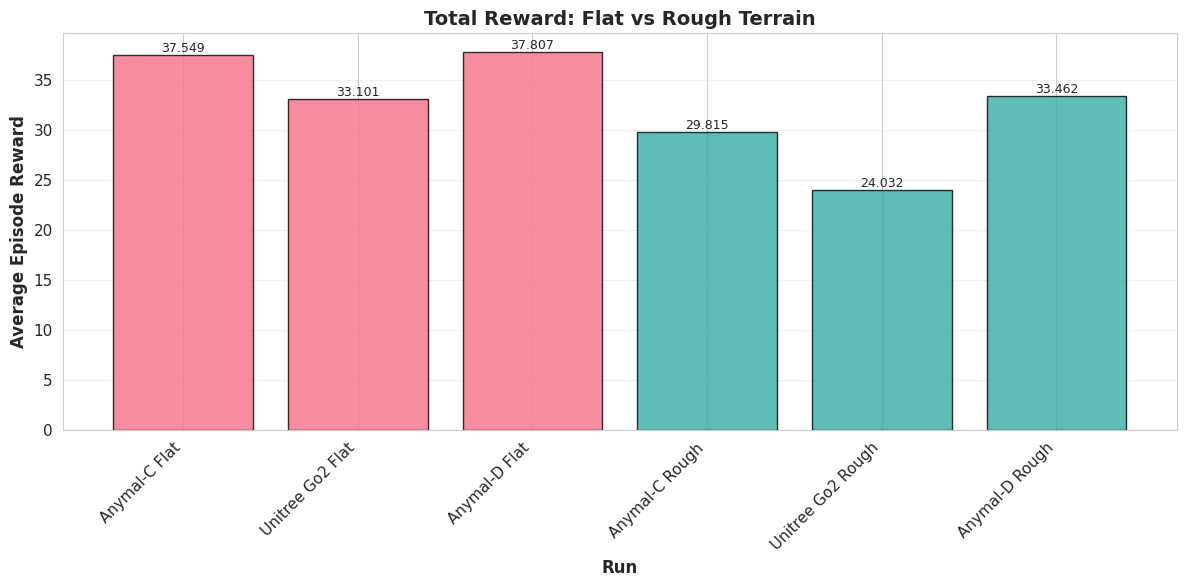

'\n# Robot comparison on rough terrain\nmetric_col = \'mean_reward\'\nif metric_col in metrics_df.columns:\n    fig, ax = plt.subplots(figsize=(10, 6))\n    plot_comparison_bar(\n        metrics_df,\n        \'robot_comparison_flat\',\n        metric_col,\n        title=\'Total Reward: Robot Platform Comparison (Flat Terrain)\',\n        ylabel=\'Average Episode Reward\',\n        ax=ax\n    )\n    # plt.savefig(OUTPUT_DIR / "robot_comparison_rough_reward.png", dpi=150, bbox_inches=\'tight\')\n    plt.show()\n'

In [52]:
# Total reward comparison
metric_col = 'mean_reward'
if metric_col in metrics_df.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_comparison_bar(
        metrics_df,
        'flat_vs_rough',
        metric_col,
        title='Total Reward: Flat vs Rough Terrain',
        ylabel='Average Episode Reward',
        ax=ax
    )
    # plt.savefig(OUTPUT_DIR / "flat_vs_rough_reward.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f"Metric {metric_col} not available")


"""
# Robot comparison on rough terrain
metric_col = 'mean_reward'
if metric_col in metrics_df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_comparison_bar(
        metrics_df,
        'robot_comparison_flat',
        metric_col,
        title='Total Reward: Robot Platform Comparison (Flat Terrain)',
        ylabel='Average Episode Reward',
        ax=ax
    )
    # plt.savefig(OUTPUT_DIR / "robot_comparison_rough_reward.png", dpi=150, bbox_inches='tight')
    plt.show()
"""


## 3. Comprehensive Chart Metrics

Grouped bar charts showing multiple metrics across different runs for easy comparison.


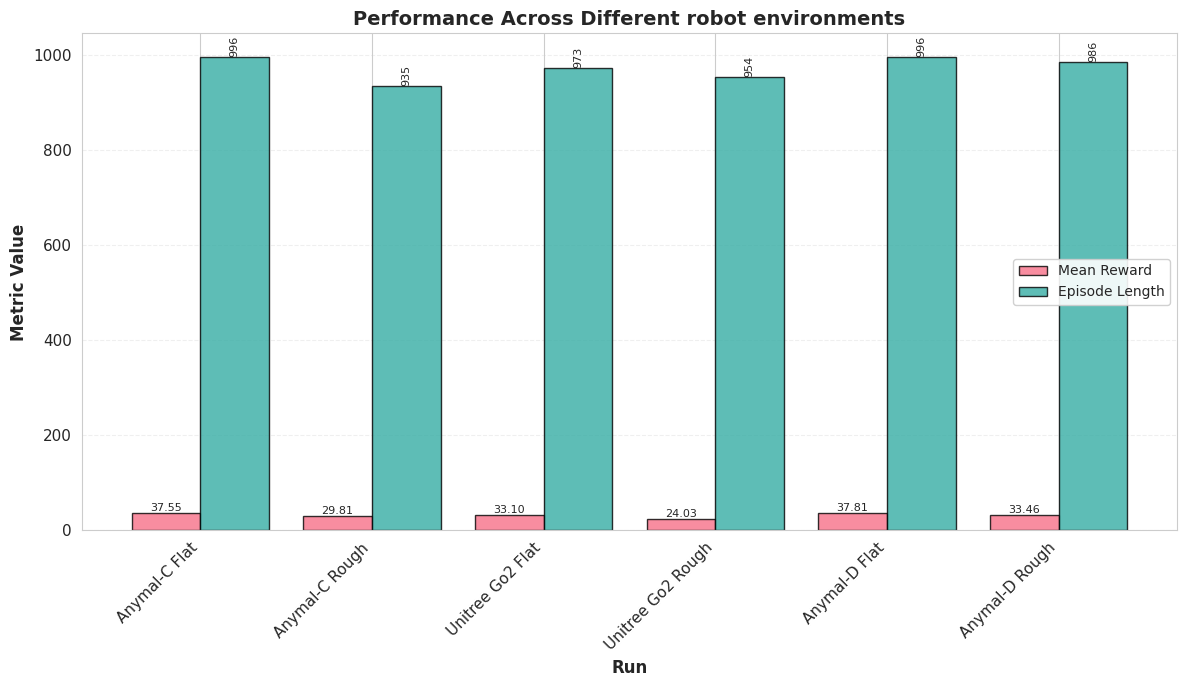

In [53]:
# Comprehensive Metrics: Flat vs Rough (Grouped Bar Chart)
metrics = [
    'mean_reward',
    'episode_length',
]

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Performance Across Different robot environments'
    )
    # plt.savefig(OUTPUT_DIR / 'flat_vs_rough_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')


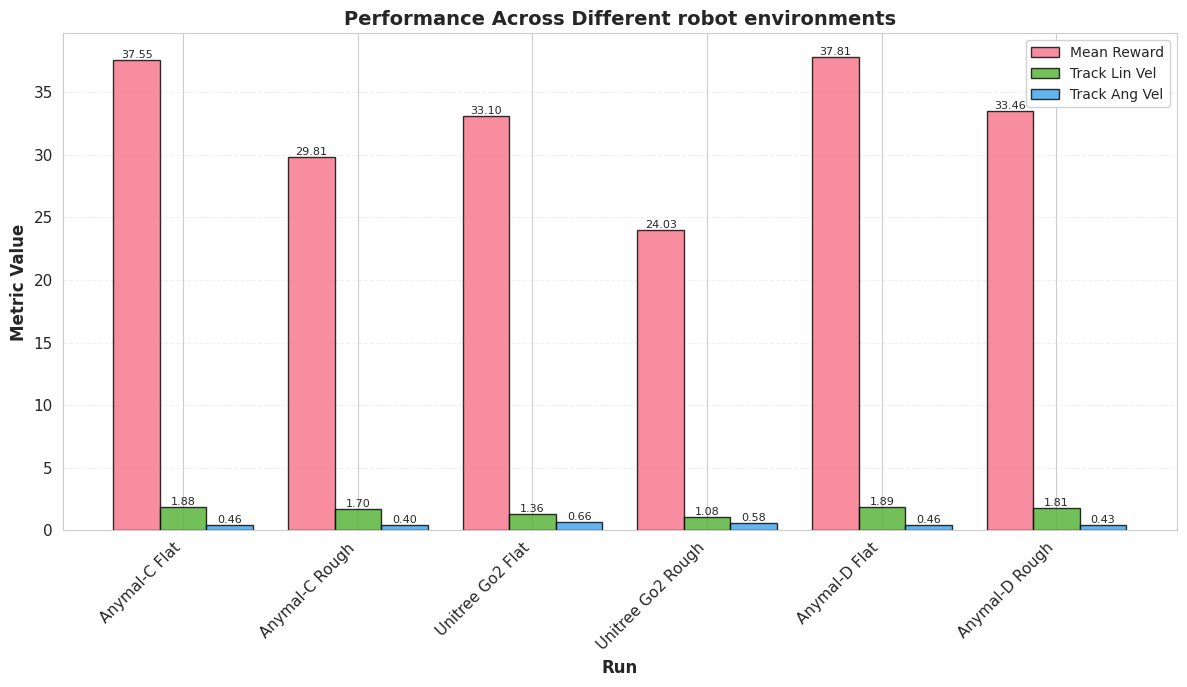

In [54]:
# Comprehensive Metrics: Flat vs Rough (Grouped Bar Chart)
metrics = [
    'mean_reward',
    'track_lin_vel',
    'track_ang_vel',
]

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Performance Across Different robot environments'
    )
    # plt.savefig(OUTPUT_DIR / 'flat_vs_rough_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')

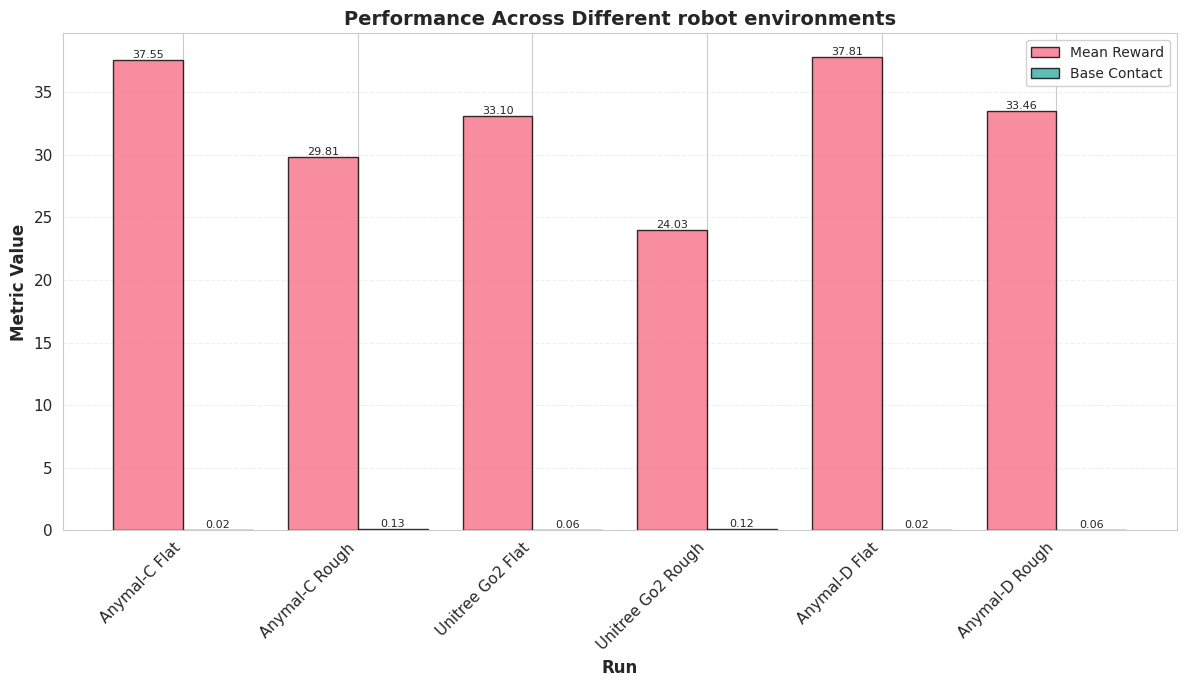

In [55]:
# Comprehensive Metrics: Flat vs Rough (Grouped Bar Chart)
metrics = [
    'mean_reward',
    'termination_penalty',
    'base_contact',
    'error_pos'
]

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Performance Across Different robot environments'
    )
    # plt.savefig(OUTPUT_DIR / 'flat_vs_rough_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')

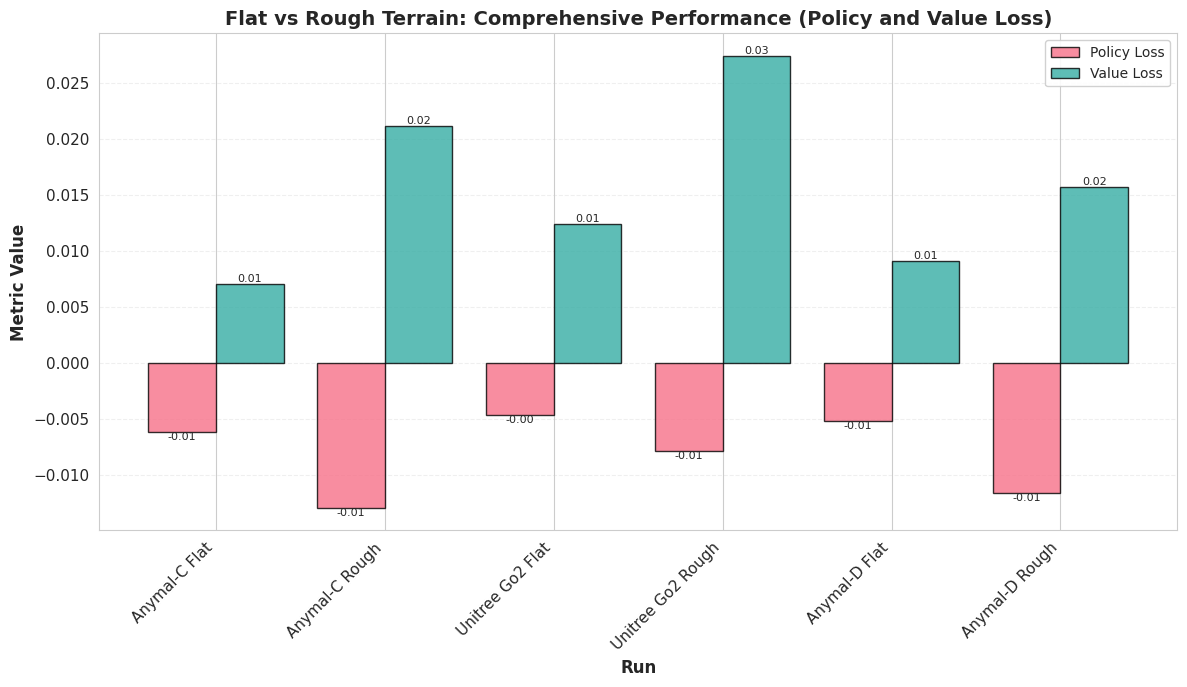

In [25]:
# Comprehensive Metrics: Flat vs Rough
metrics = [
    'policy_loss',
    'value_loss',
]

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Flat vs Rough Terrain: Comprehensive Performance (Policy and Value Loss)'
    )
    # plt.savefig(OUTPUT_DIR / 'flat_vs_rough_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')


## 7. Statistical Summary and Insights

Generate statistical summaries and key insights from the comparisons.


In [63]:
# Statistical summary by category
print("="*80)
print("STATISTICAL SUMMARY")
print("="*80)

summary_cols = ['mean_reward', 'episode_length']
available_summary_cols = [c for c in summary_cols if c in metrics_df.columns]

if available_summary_cols:
    print("\nSummary by Category:")
    category_summary = metrics_df.groupby('category')[available_summary_cols].agg(['mean', 'std', 'min', 'max'])
    display(category_summary)
    
    # Full metrics table
    print("\nFull Metrics Table (Latest Checkpoint Values):")
    display_cols = ['display_name', 'experiment', 'category'] + available_summary_cols
    full_table = metrics_df[display_cols].sort_values(by='mean_reward', ascending=False)
    display(full_table)
    
    # Save summary
    # full_table.to_csv(OUTPUT_DIR / "full_metrics_summary.csv", index=False)
    # print(f"\nFull summary saved to: {OUTPUT_DIR / 'full_metrics_summary.csv'}")


STATISTICAL SUMMARY

Summary by Category:


mean_reward                                 episode_length  \
                mean       std        min        max           mean   
category                                                              
flat       36.152056  2.645627  33.100784  37.806713     988.146667   
rough      29.102799  4.755079  24.031946  33.461853     958.026672   

                                             
                std         min         max  
category                                     
flat      12.996158  973.140015  995.669983  
rough     25.751471  934.650024  985.630005


Full Metrics Table (Latest Checkpoint Values):


,display_name,experiment,category,mean_reward,episode_length
4,Anymal-D Flat,anymal_d_flat,flat,37.806713,995.669983
0,Anymal-C Flat,anymal_c_flat,flat,37.548672,995.630005
5,Anymal-D Rough,anymal_d_rough,rough,33.461853,985.630005
2,Unitree Go2 Flat,unitree_go2_flat,flat,33.100784,973.140015
1,Anymal-C Rough,anymal_c_rough,rough,29.814598,934.650024
3,Unitree Go2 Rough,unitree_go2_rough,rough,24.031946,953.799988


Target mean_reward: 20.0

Steps / hours to reach target (sorted by steps):


,run_key,display_name,experiment,category,steps_to_target,hours_to_target
0,anymal_c_flat/2025-12-02_09-04-49,Anymal-C Flat,anymal_c_flat,flat,86,0.023790
4,anymal_d_flat/2025-12-02_09-22-05,Anymal-D Flat,anymal_d_flat,flat,95,0.022371
5,anymal_d_rough/2025-12-02_13-22-21,Anymal-D Rough,anymal_d_rough,rough,117,0.142807
1,anymal_c_rough/2025-12-02_10-14-00,Anymal-C Rough,anymal_c_rough,rough,122,0.145762
2,unitree_go2_flat/2025-12-02_09-42-57,Unitree Go2 Flat,unitree_go2_flat,flat,358,0.076026
3,unitree_go2_rough/2025-12-02_15-15-57,Unitree Go2 Rough,unitree_go2_rough,rough,446,1.011196


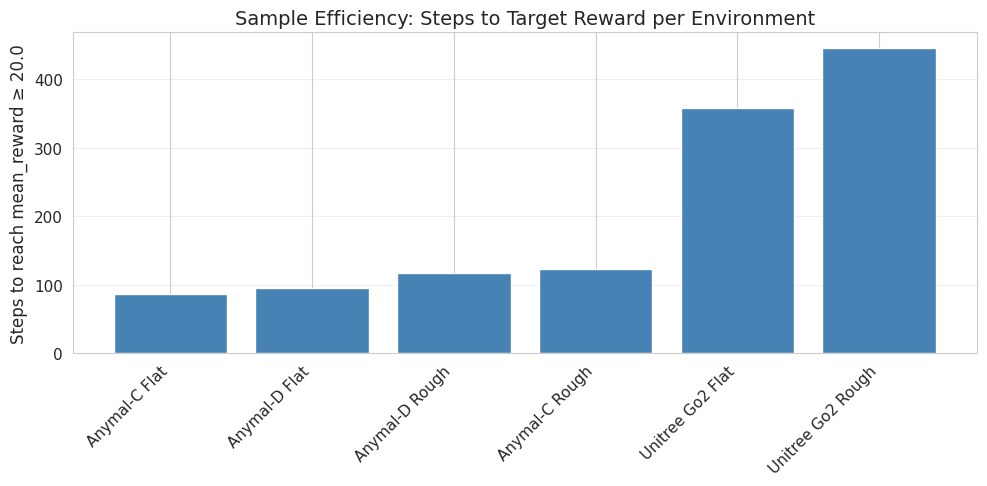

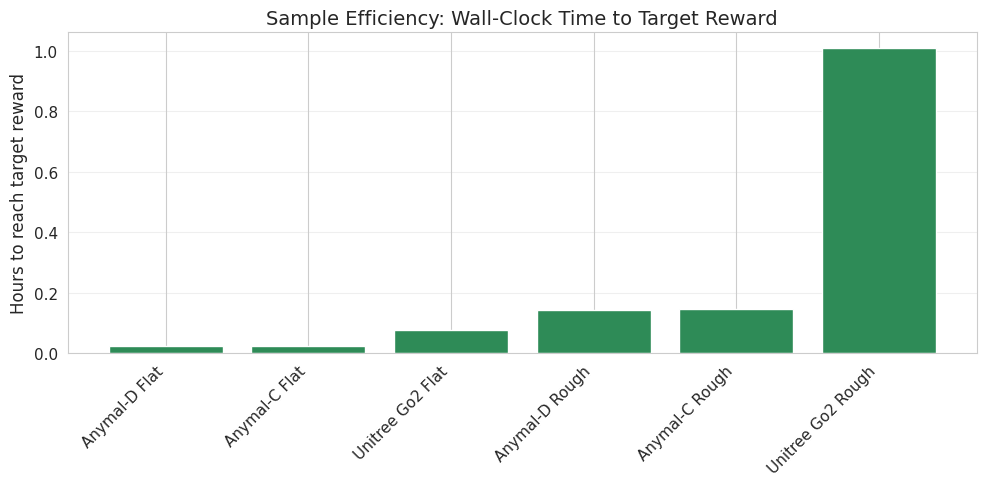

In [64]:
# 8. Sample Efficiency: Steps and Time to Reach Target Reward per Robot

TARGET_REWARD = 20.0  # you can adjust this threshold

records = []
for run_key, run_data in all_metrics.items():
    metrics = run_data["metrics"]

    # Find the mean_reward metric tag for this run
    mean_tag = find_metric_name(metrics, METRIC_PATTERNS["mean_reward"]) if "mean_reward" in METRIC_PATTERNS else None
    if mean_tag is None:
        print(f"Skipping {run_data['display_name']}: no mean_reward metric found")
        continue

    df = metrics[mean_tag].copy()
    if df.empty:
        print(f"Skipping {run_data['display_name']}: empty mean_reward trajectory")
        continue

    # Ensure sorted by step
    df = df.sort_values("step")

    # First step where mean_reward >= TARGET_REWARD
    reached = df[df["value"] >= TARGET_REWARD]
    if not reached.empty:
        first = reached.iloc[0]
        steps_to_target = int(first["step"])
        wall_time_to_target = float(first["wall_time"] - df["wall_time"].iloc[0])  # seconds since run start
    else:
        steps_to_target = np.nan
        wall_time_to_target = np.nan

    records.append({
        "run_key": run_key,
        "display_name": run_data["display_name"],
        "experiment": run_data["experiment"],
        "category": run_data["category"],
        "steps_to_target": steps_to_target,
        "hours_to_target": wall_time_to_target / 3600.0 if not np.isnan(wall_time_to_target) else np.nan,
    })

sample_eff_df = pd.DataFrame(records)

print(f"Target mean_reward: {TARGET_REWARD}")
print("\nSteps / hours to reach target (sorted by steps):")
display(sample_eff_df.sort_values("steps_to_target"))

# Bar plot: steps to target per robot/environment
valid_steps = sample_eff_df.dropna(subset=["steps_to_target"]).sort_values("steps_to_target")
if not valid_steps.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(valid_steps["display_name"], valid_steps["steps_to_target"], color="steelblue")
    ax.set_ylabel(f"Steps to reach mean_reward ≥ {TARGET_REWARD}", fontsize=12)
    ax.set_title("Sample Efficiency: Steps to Target Reward per Environment", fontsize=14)
    ax.set_xticklabels(valid_steps["display_name"], rotation=45, ha="right")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Optional: bar plot of wall-clock hours to target (if wall_time is available)
valid_hours = sample_eff_df.dropna(subset=["hours_to_target"]).sort_values("hours_to_target")
if not valid_hours.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(valid_hours["display_name"], valid_hours["hours_to_target"], color="seagreen")
    ax.set_ylabel("Hours to reach target reward", fontsize=12)
    ax.set_title("Sample Efficiency: Wall-Clock Time to Target Reward", fontsize=14)
    ax.set_xticklabels(valid_hours["display_name"], rotation=45, ha="right")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


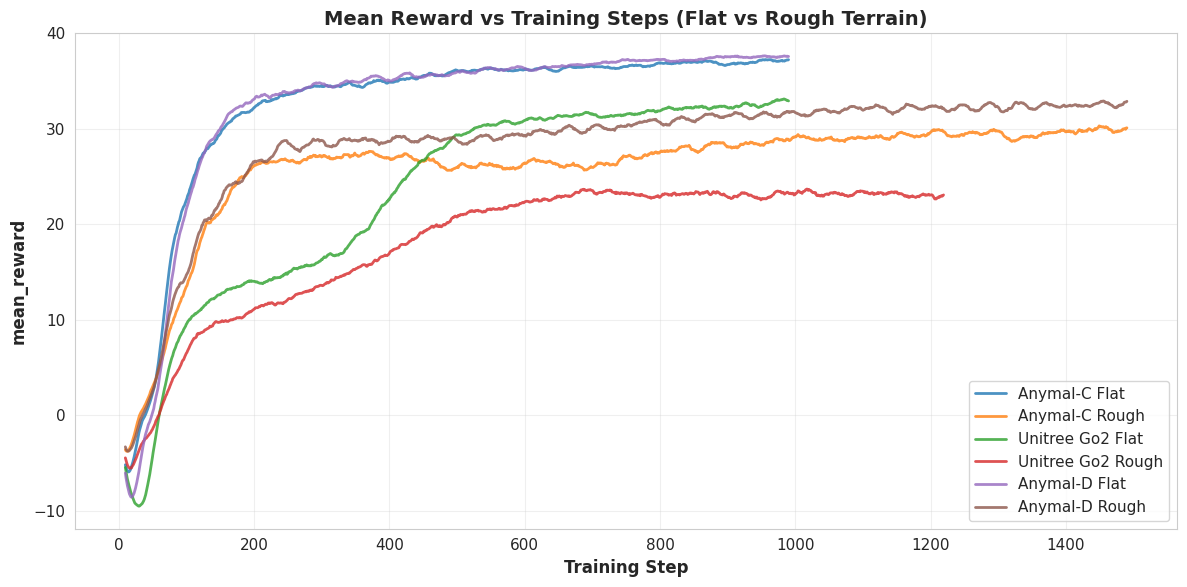

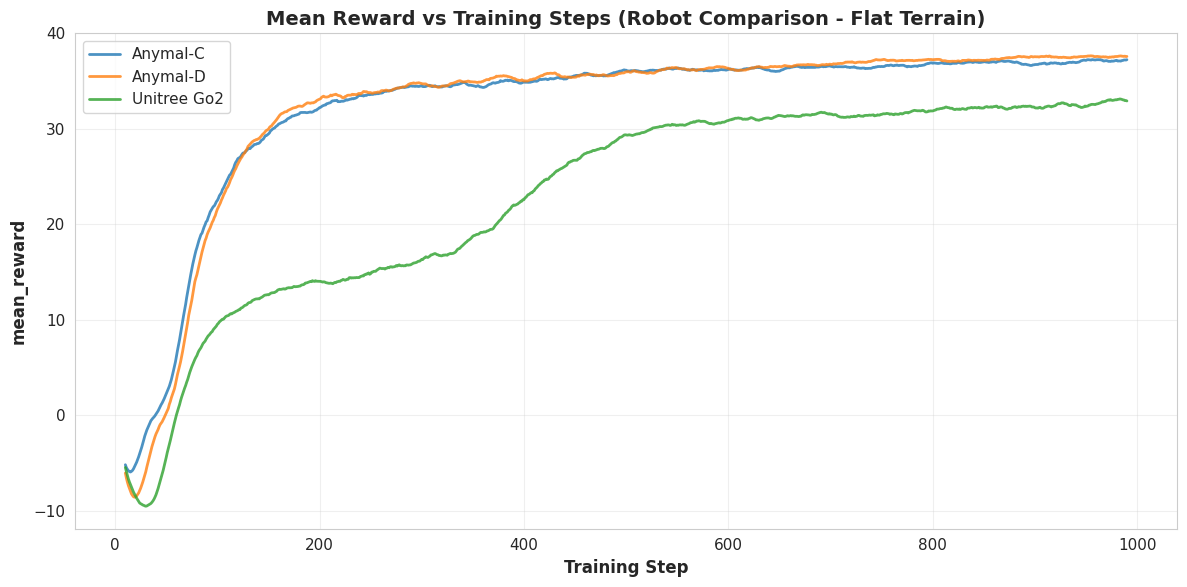

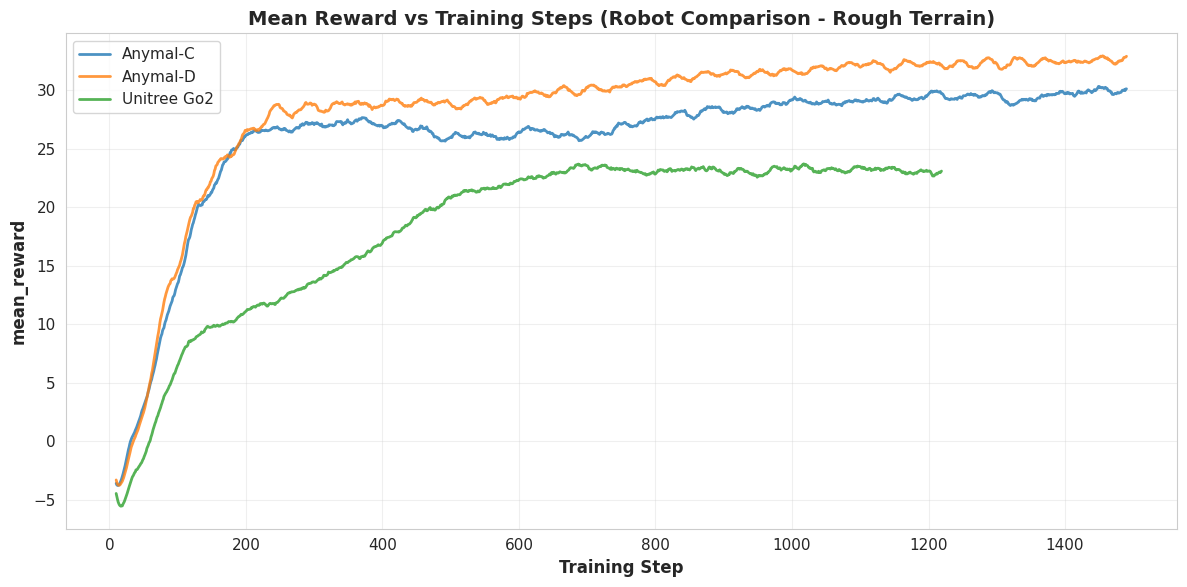

In [58]:
# 9. Learning Curves: Mean Reward vs Training Steps Across Environments

# Flat vs Rough comparison
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_curves(
    all_metrics,
    comparison_group='flat_vs_rough',
    metric_name='mean_reward',
    title='Mean Reward vs Training Steps (Flat vs Rough Terrain)',
    smoothing=20,
    ax=ax,
)
plt.show()

# Robot comparison on flat terrain
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_curves(
    all_metrics,
    comparison_group='robot_comparison_flat',
    metric_name='mean_reward',
    title='Mean Reward vs Training Steps (Robot Comparison - Flat Terrain)',
    smoothing=20,
    ax=ax,
)
plt.show()

# Robot comparison on rough terrain
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_curves(
    all_metrics,
    comparison_group='robot_comparison_rough',
    metric_name='mean_reward',
    title='Mean Reward vs Training Steps (Robot Comparison - Rough Terrain)',
    smoothing=20,
    ax=ax,
)
plt.show()


In [62]:
print("="*80)
print("KEY INSIGHTS AND FINDINGS")
print("="*80)

insights = []

# Convenience: flat/rough split per robot from metrics_df
summary_cols = ["mean_reward", "episode_length"]
robots = ["Anymal-C", "Anymal-D", "Unitree Go2"]

# Map display names in metrics_df to a simple robot key and terrain
def parse_name(name: str):
    # Assumes names like "Anymal-C Flat", "Unitree Go2 Rough"
    parts = name.split()
    robot = " ".join(parts[:-1])   # all but last
    terrain = parts[-1].lower()    # "Flat"/"Rough"
    return robot, terrain

robot_stats = {}
for _, row in metrics_df.iterrows():
    robot, terrain = parse_name(row["display_name"])
    if robot not in robots:
        continue
    key = (robot, terrain)
    robot_stats[key] = row

# 1. Terrain difficulty impact per robot
flat_means, rough_means = [], []
for robot in robots:
    flat_row = robot_stats.get((robot, "flat"))
    rough_row = robot_stats.get((robot, "rough"))
    if flat_row is None or rough_row is None:
        continue
    flat = flat_row["mean_reward"]
    rough = rough_row["mean_reward"]
    flat_means.append(flat)
    rough_means.append(rough)
    drop_pct = (flat - rough) / flat * 100.0 if flat != 0 else 0.0
    insights.append({
        "Finding": "Terrain Difficulty Impact",
        "Detail": (
            f"{robot}: rough terrain mean reward is {drop_pct:.1f}% lower than flat "
            f"({flat:.2f} → {rough:.2f})."
        ),
    })

overall_flat = np.mean(flat_means)
overall_rough = np.mean(rough_means)
overall_drop = (overall_flat - overall_rough) / overall_flat * 100.0
insights.insert(0, {
    "Finding": "Terrain Difficulty Impact (Overall)",
    "Detail": (
        f"Across robots, rough terrain reduces final mean reward by "
        f"{overall_drop:.1f}% on average "
        f"({overall_flat:.2f} → {overall_rough:.2f})."
    ),
})

# 2. Best performing policy (flat)
flat_only = metrics_df[metrics_df["category"] == "flat"]
if "mean_reward" in flat_only.columns and not flat_only.empty:
    best_flat = flat_only.loc[flat_only["mean_reward"].idxmax()]
    second_flat = flat_only.sort_values("mean_reward", ascending=False).iloc[1]
    gap_pct = (best_flat["mean_reward"] - second_flat["mean_reward"]) / second_flat["mean_reward"] * 100.0
    insights.append({
        "Finding": "Best Performing Policy (Flat Terrain)",
        "Detail": (
            f"{best_flat['display_name']} achieves the highest total reward "
            f"({best_flat['mean_reward']:.2f}), "
            f"about {gap_pct:.1f}% higher than {second_flat['display_name']}."
        ),
        "Experiment": best_flat["experiment"],
    })

# 3. Sample efficiency from previously computed sample_eff_df
if "sample_eff_df" in globals():
    eff = sample_eff_df.dropna(subset=["steps_to_target"]).sort_values("steps_to_target")
    if not eff.empty:
        best = eff.iloc[0]
        worst = eff.iloc[-1]
        factor_steps = worst["steps_to_target"] / best["steps_to_target"]
        insights.append({
            "Finding": "Sample Efficiency (Steps to Target)",
            "Detail": (
                f"{best['display_name']} reaches the target reward in the fewest steps "
                f"({best['steps_to_target']:.0f} steps). "
                f"{worst['display_name']} is the slowest, needing about "
                f"{factor_steps:.1f}× more steps ({worst['steps_to_target']:.0f} steps)."
            ),
        })
    eff_t = sample_eff_df.dropna(subset=["hours_to_target"]).sort_values("hours_to_target")
    if not eff_t.empty:
        best_t = eff_t.iloc[0]
        worst_t = eff_t.iloc[-1]
        factor_time = worst_t["hours_to_target"] / best_t["hours_to_target"]
        insights.append({
            "Finding": "Sample Efficiency (Wall-Clock Time)",
            "Detail": (
                f"{best_t['display_name']} reaches the target in about "
                f"{best_t['hours_to_target']*60:.1f} minutes, while "
                f"{worst_t['display_name']} needs about "
                f"{worst_t['hours_to_target']:.2f} hours "
                f"(~{factor_time:.1f}× longer)."
            ),
        })

# 4. Training stability
if "episode_length" in metrics_df.columns:
    stable_runs = metrics_df[metrics_df["episode_length"] >
                             metrics_df["episode_length"].quantile(0.75)]
    insights.append({
        "Finding": "Training Stability",
        "Detail": (
            f"{len(stable_runs)} policies show high episode stability "
            f"(top 25% episode lengths), including "
            f"{', '.join(stable_runs['display_name'].tolist())}."
        )
    })

# Print nicely
for i, ins in enumerate(insights, 1):
    print(f"\n{i}. {ins['Finding']}")
    print(f"   {ins['Detail']}")
    for k, v in ins.items():
        if k not in ["Finding", "Detail"]:
            print(f"   {k}: {v}")

KEY INSIGHTS AND FINDINGS

1. Terrain Difficulty Impact (Overall)
   Across robots, rough terrain reduces final mean reward by 19.5% on average (36.15 → 29.10).

2. Terrain Difficulty Impact
   Anymal-C: rough terrain mean reward is 20.6% lower than flat (37.55 → 29.81).

3. Terrain Difficulty Impact
   Anymal-D: rough terrain mean reward is 11.5% lower than flat (37.81 → 33.46).

4. Terrain Difficulty Impact
   Unitree Go2: rough terrain mean reward is 27.4% lower than flat (33.10 → 24.03).

5. Best Performing Policy (Flat Terrain)
   Anymal-D Flat achieves the highest total reward (37.81), about 0.7% higher than Anymal-C Flat.
   Experiment: anymal_d_flat

6. Sample Efficiency (Steps to Target)
   Anymal-C Flat reaches the target reward in the fewest steps (86 steps). Unitree Go2 Rough is the slowest, needing about 5.2× more steps (446 steps).

7. Sample Efficiency (Wall-Clock Time)
   Anymal-D Flat reaches the target in about 1.3 minutes, while Unitree Go2 Rough needs about 1.01 hou